In [4]:
!pip install matplotlib

  Using cached kiwisolver-1.3.1-cp38-cp38-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [20]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=[224,224]
train_path='Images/Train'
test_path='Images/Test'

In [22]:
vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [23]:
for layer in vgg.layers:
    layer.trainable=False

In [41]:
os.chdir('F:\Face\Self Trained Models')

In [42]:
folders=glob('Images/Train')
path=os.getcwd()+'\Images\Train'
print(len(os.listdir(path)))

2


In [43]:
x=Flatten()(vgg.output)
prediction=Dense(len(os.listdir(path)),activation='softmax')(x)

In [44]:
model=Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [45]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis = -1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)), axis = -1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    
    return loss

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [48]:
tf.test.is_built_with_cuda()

True

In [49]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [50]:
'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the model

r = model.fit_generator(
training_set,
validation_data=test_set,
epochs=5,
steps_per_epoch=len(training_set),
validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
4/4 [==============================] - 24s 6s/step - loss: 0.7051 - accuracy: 0.7000 - val_loss: 0.1327 - val_accuracy: 1.0000
Epoch 2/5
4/4 [==============================] - 27s 7s/step - loss: 0.2030 - accuracy: 0.9300 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/5
4/4 [==============================] - 23s 6s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 27s 7s/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 28s 7s/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000


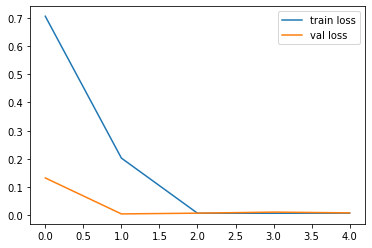

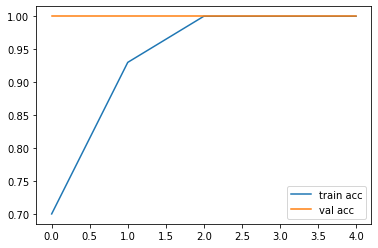

<Figure size 432x288 with 0 Axes>

In [51]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [52]:
model.save('facefeatures_new_model.h5')